# *This file allows to generate all plots necessary for figures*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, Polynomials, LaTeXStrings, ColorSchemes, DelimitedFiles, DataFrames
using Statistics, StatsPlots, Random, ProgressMeter, Printf, LinearAlgebra, Plots.PlotMeasures
using ImplicitPlots
include("DA_kinetics.jl") # Loading of DA kinetics of gating variables
include("DA_models.jl") # Loading of DA model
include("DA_utils.jl"); # Loading of some utils functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 20000
const tspan  = (0.0, Tfinal)
tt = 0. : 0.01 : Tfinal
tt_rand = 0. : 1 : Tfinal

# Definition of reversal potential values (in mV), [Mg] and membrane capacitance
const VNa     = 60. # Sodium reversal potential
const VK      = -90. # Potassium reversal potential
const VCa     = 50. # Calcium reversal potential
const VH      = -29. # H reversal potential
const VLNS    = -65. # Leak reversal potential
const EPacemaker = 4.2732015978991615 # Reversal potential of pacemaking channels

const C       = 1. # Membrane capacitance
const fCa     = 0.018 # Fraction of unbuffered free calcium
const ICapmax = 11 # Maximum calcium pump current
const F       = 96520 # Faraday constant in ms*µA/mmol (and taking cm³=mL)
const d       = 15 # Soma diameter in cm
const L       = 25 # Soma length

# Definition of voltage range for the DICs
const Vmin = -100 
const Vmax = 50
const Vrange = range(Vmin, stop=Vmax, step=0.0154640);

In [3]:
# Modifying backend GR attributes
gr(guidefontsize=25, tickfontsize=15, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1);
default(fmt = :png);

In [4]:
Vs(n; eps=0.01) = -25.0 - 12.0 * log((1 - clamp(n, eps, 1 - eps)) / clamp(n, eps, 1 - eps))

# Define a struct (optional, but useful if you need parameters)
struct NoisyFunction
    amplitude::Float64  # amplitude of the noise
end

# Overload the () operator to make the struct callable
function (nf::NoisyFunction)(x::Float64)
    noise = nf.amplitude * randn()  # Generate Gaussian noise (mean 0, std 1)
    return noise  # Example function with noise
end

function condition(u,t,integrator) # Event when event_f(u,t) == 0
  (u[1]- (-20.))
end

function affect!(integrator)
end

cb = ContinuousCallback(condition, affect!, nothing, save_positions = (true, false));

# Original model

In [5]:
function DA_ODE_planar(du, u, p, t)
    # Parameters
    Iapp       = p[1](t) # Amplitude of external current
    gNa        = p[2] # Sodium current maximal conductance
    gKd        = p[3] # Delayed-rectifier potassium current maximal conductance
    gLNS       = p[4] # Leak non specific current maximal conductance
    
    # Variables
    V = u[1] # Membrane potential
    n = u[2] # Delayed-rectifier potassium current activation
    
    # ODEs
                    # Sodium current
    du[1] = (1/C) * (- gNa*m_inf(V)^3*h_inf(Vs(n))*(V-VNa) +
                    # Potassium current
                    - gKd*n^3*(V-VK) +
                    # Passive currents
                    - gLNS*(V-VLNS) +
                    # Stimulation currents
                    + Iapp)

    du[2] = (1/tau_n(V)) * (n_inf(V) - n)
end

DA_ODE_planar (generic function with 1 method)

In [6]:
gNa        = 25. # Sodium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance

# Input current definition
Iapp(t) = 0 # pA
p = (Iapp, gNa, gKd, gLNS)

# Initial conditions
V0 = -50.
x0 = [V0, n_inf(V0)]

# Simulation
prob = ODEProblem(DA_ODE_planar, x0, tspan, p) # Describing the problem
sol = solve(prob; maxiters=1e6); # Solving the problem

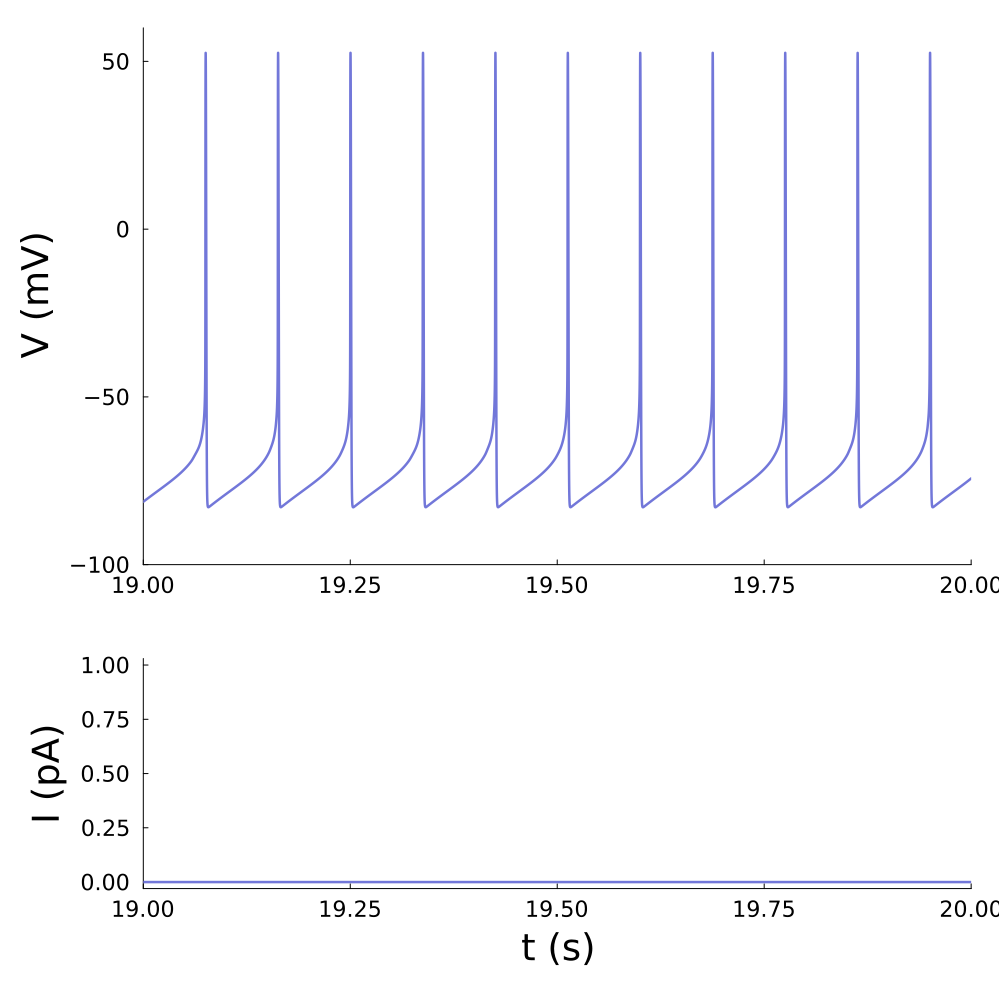

In [7]:
# Retrieving variables
x         = sol(tt)
V_plot    = x[1, :]
voltage = plot(tt./1e3, V_plot, linewidth=2.5, color=myDarkBlue, 
    legend=false, ylims=(-100, 60), margins=20Plots.px, size=(1200, 800))
ylabel!("V (mV)")

current = plot(tt./1e3, Iapp.(tt), linewidth=2.5, color=myDarkBlue,
    legend=false, margins=20Plots.px, size=(1200, 800))
ylabel!("I (pA)")
xlabel!("t (s)")

l = @layout [
    a{1.0*w, 0.70*h}
    b{1.0*w, 0.30*h}
]
VI = plot(voltage, current, layout=l, size=(1000, 1000), margins=20Plots.px, xlims=(19., 20.))
display(VI)

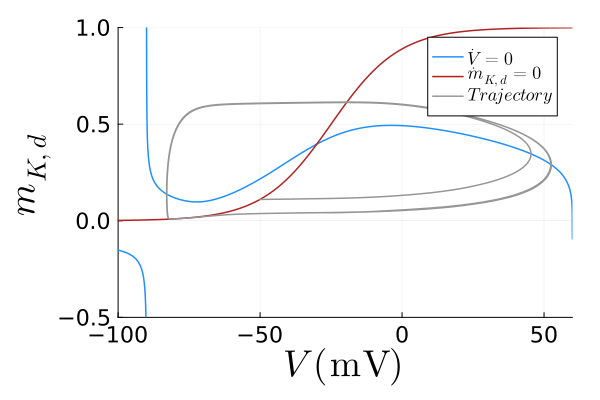

In [8]:
                         # Sodium current
dot_V2(V, n) = (1/C) * (- gNa*m_inf(V)^3*h_inf(Vs(n))*(V-VNa) +
                    # Potassium current
                    - gKd*n^3*(V-VK) +
                    # Passive currents
                    - gLNS*(V-VLNS))

dot_mKd(V, n) = (1/tau_n(V)) * (n_inf(V) - n)

p = implicit_plot(dot_V2, linewidth=1.5, xlims=(-100, 60), ylims=(-0.5, 1), 
              aspect_ratio=:auto, linecolor=:dodgerblue, label=L"\dot V = 0")
implicit_plot!(dot_mKd, linewidth=1.5, xlims=(-100, 60), ylims=(-0.5, 1), 
               aspect_ratio=:auto, linecolor=:firebrick, label=L"\dot m_{K,d} = 0")
plot!(x[1, :], x[2, :], linewidth=1.5, linecolor=myGray, label=L"Trajectory")
xlabel!(L"V\ (\mathrm{mV})")
ylabel!(L"m_{K,d}")
# savefig(p, "./figures/phase_plane_original.pdf")
# savefig(p, "./figures/phase_plane_original.svg")

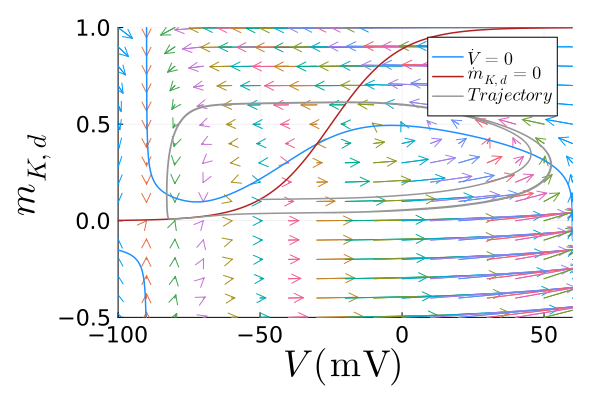

In [9]:
# Define the grid ranges
xx = -100:10:60
yy = -0.5:0.1:1.0

# Create grid using broadcasting
X = repeat(xx', length(yy), 1)   # transpose x to make rows
Y = repeat(yy, 1, length(xx))    # repeat y as columns

# Evaluate the vector field on the grid
U = dot_V2.(X, Y)
V = dot_mKd.(X, Y)

# Plot the vector field
scale_factor = 0.05
quiver(X, Y, quiver=(scale_factor .* U, scale_factor .* V), arrow=true)
implicit_plot!(dot_V2, linewidth=1.5, xlims=(-100, 60), ylims=(-0.5, 1), 
              aspect_ratio=:auto, linecolor=:dodgerblue, label=L"\dot V = 0")
implicit_plot!(dot_mKd, linewidth=1.5, xlims=(-100, 60), ylims=(-0.5, 1), 
               aspect_ratio=:auto, linecolor=:firebrick, label=L"\dot m_{K,d} = 0")
plot!(x[1, :], x[2, :], linewidth=1.5, linecolor=myGray, label=L"Trajectory")
xlabel!(L"V\ (\mathrm{mV})")
ylabel!(L"m_{K,d}")

# Planar model with pacemaking

In [21]:
function DA_ODE_planar_true(du, u, p, t)
    # Parameters
    Iapp       = p[1](t) # Amplitude of external current
    gNa        = p[2] # Sodium current maximal conductance
    gKd        = p[3] # Delayed-rectifier potassium current maximal conductance
    gLNS       = p[4] # Leak non specific current maximal conductance
    gPacemaker = p[5] # Pacemaking current maximal conductance
    
    # Variables
    V = u[1] # Membrane potential
    n = u[2] # Delayed-rectifier potassium current activation
    
    # ODEs
                    # Sodium current
    du[1] = (1/C) * (- gNa*m_inf_true(V)^3*h_inf(Vs(n))*(V-VNa) +
                    # Potassium current
                    - gKd*n^3*(V-VK) - gPacemaker*mPacemaker_inf(V)*(V-EPacemaker) +
                    # Passive currents
                    - gLNS*(V-VLNS) +
                    # Stimulation currents
                    + Iapp)

    du[2] = (1/tau_n(V)) * (n_inf(V) - n)
end

DA_ODE_planar_true (generic function with 1 method)

In [22]:
function DA_ODE_planar_true_20ms(du, u, p, t)
    # Parameters
    Iapp       = p[1](t) # Amplitude of external current
    gNa        = p[2] # Sodium current maximal conductance
    gKd        = p[3] # Delayed-rectifier potassium current maximal conductance
    gLNS       = p[4] # Leak non specific current maximal conductance
    gPacemaker = p[5] # Pacemaking current maximal conductance
    
    # Variables
    V = u[1] # Membrane potential
    n = u[2] # Delayed-rectifier potassium current activation
    
    # ODEs
                    # Sodium current
    du[1] = (1/C) * (- gNa*m_inf_true(V)^3*h_inf(Vs(n))*(V-VNa) +
                    # Potassium current
                    - gKd*n^3*(V-VK) - gPacemaker*mPacemaker_inf(V)*(V-EPacemaker) +
                    # Passive currents
                    - gLNS*(V-VLNS) +
                    # Stimulation currents
                    + Iapp)

    du[2] = (1/(20)) * (n_inf(V) - n)
end

DA_ODE_planar_true_20ms (generic function with 1 method)

In [37]:
gNa        = 25. # Sodium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Input current definition
Iapp(t) = 0. # pA
p = (Iapp, gNa, gKd, gLNS, gPacemaker)

# Initial conditions
V0 = -50.
x0 = [V0, n_inf(V0)]

# Simulation
prob = ODEProblem(DA_ODE_planar_true, x0, tspan, p) # Describing the problem
sol = solve(prob; maxiters=1e6); # Solving the problem

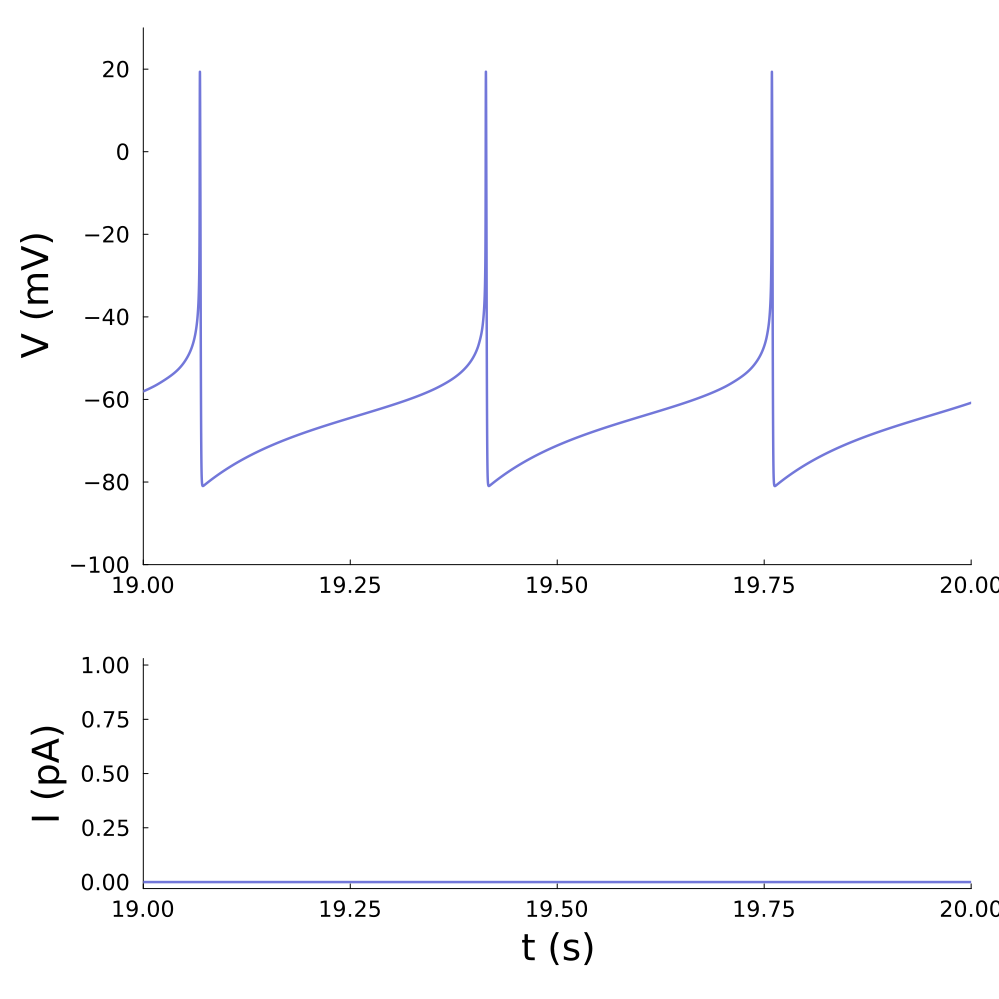

In [38]:
# Retrieving variables
x         = sol(tt)
V_plot    = x[1, :]
voltage = plot(tt./1e3, V_plot, linewidth=2.5, color=myDarkBlue, 
    legend=false, ylims=(-100, 30), margins=20Plots.px, size=(1200, 800))
ylabel!("V (mV)")

current = plot(tt./1e3, Iapp.(tt), linewidth=2.5, color=myDarkBlue,
    legend=false, margins=20Plots.px, size=(1200, 800))
ylabel!("I (pA)")
xlabel!("t (s)")

l = @layout [
    a{1.0*w, 0.70*h}
    b{1.0*w, 0.30*h}
]
VI = plot(voltage, current, layout=l, size=(1000, 1000), margins=20Plots.px, xlims=(19., 20.))
display(VI)

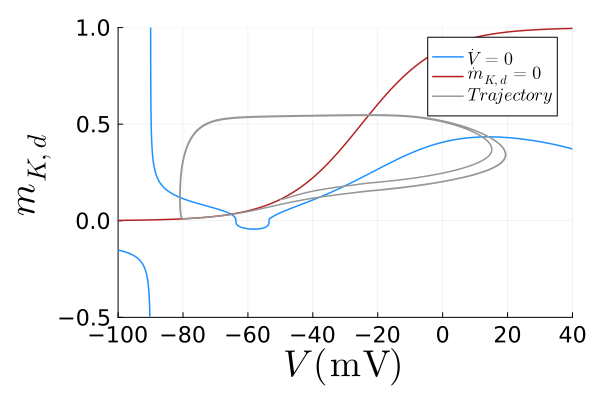

In [39]:
                         # Sodium current
dot_V(V, n) = (1/C) * (- gNa*m_inf_true(V)^3*h_inf(Vs(n))*(V-VNa) +
                    # Potassium current
                    - gKd*n^3*(V-VK) - 0*mPacemaker_inf(V)*(V-EPacemaker) +
                    # Passive currents
                    - gLNS*(V-VLNS))

dot_mKd(V, n) = (1/tau_n(V)) * (n_inf(V) - n)

p = implicit_plot(dot_V, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
              aspect_ratio=:auto, linecolor=:dodgerblue, label=L"\dot V = 0")
implicit_plot!(dot_mKd, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
               aspect_ratio=:auto, linecolor=:firebrick, label=L"\dot m_{K,d} = 0")
plot!(x[1, :], x[2, :], linewidth=1.5, linecolor=myGray, label=L"Trajectory")
xlabel!(L"V\ (\mathrm{mV})")
ylabel!(L"m_{K,d}")
# savefig(p, "./figures/phase_plane_pacemaker.pdf")
# savefig(p, "./figures/phase_plane_pacemaker.svg")

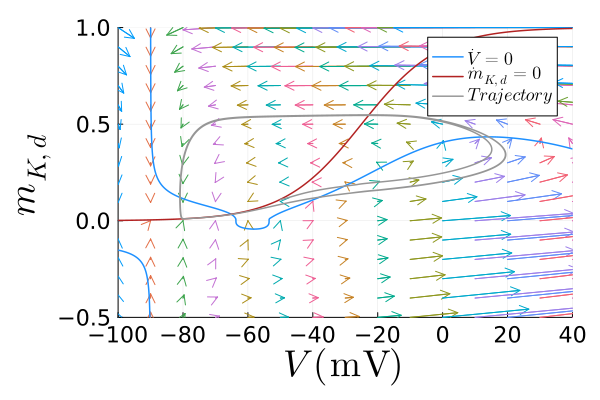

In [40]:
# Define the grid ranges
xx = -100:10:60
yy = -0.5:0.1:1.0

# Create grid using broadcasting
X = repeat(xx', length(yy), 1)   # transpose x to make rows
Y = repeat(yy, 1, length(xx))    # repeat y as columns

# Evaluate the vector field on the grid
U = dot_V.(X, Y)
V = dot_mKd.(X, Y)

# Plot the vector field
scale_factor = 0.05
quiver(X, Y, quiver=(scale_factor .* U, scale_factor .* V), arrow=true)
implicit_plot!(dot_V, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
              aspect_ratio=:auto, linecolor=:dodgerblue, label=L"\dot V = 0")
implicit_plot!(dot_mKd, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
               aspect_ratio=:auto, linecolor=:firebrick, label=L"\dot m_{K,d} = 0")
plot!(x[1, :], x[2, :], linewidth=1.5, linecolor=myGray, label=L"Trajectory")
xlabel!(L"V\ (\mathrm{mV})")
ylabel!(L"m_{K,d}")

In [16]:
gNa        = 25. # Sodium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Input current definition
Iapp(t) = 0. # pA
p = (Iapp, gNa, gKd, gLNS, gPacemaker)

# Initial conditions
V0 = -50.
x0 = [V0, n_inf(V0)]

# Simulation
prob = ODEProblem(DA_ODE_planar_true_20ms, x0, tspan, p) # Describing the problem
sol = solve(prob; maxiters=1e6); # Solving the problem

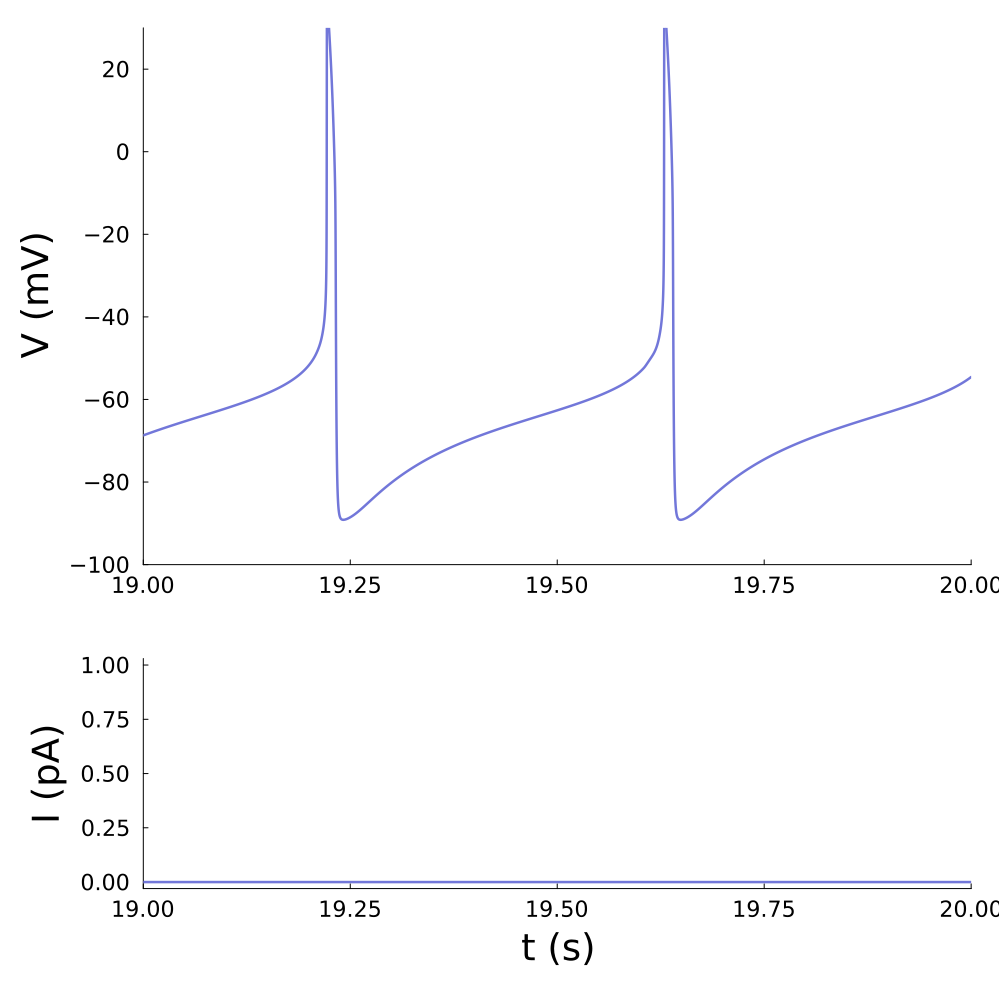

In [17]:
# Retrieving variables
x         = sol(tt)
V_plot    = x[1, :]
voltage = plot(tt./1e3, V_plot, linewidth=2.5, color=myDarkBlue, 
    legend=false, ylims=(-100, 30), margins=20Plots.px, size=(1200, 800))
ylabel!("V (mV)")

current = plot(tt./1e3, Iapp.(tt), linewidth=2.5, color=myDarkBlue,
    legend=false, margins=20Plots.px, size=(1200, 800))
ylabel!("I (pA)")
xlabel!("t (s)")

l = @layout [
    a{1.0*w, 0.70*h}
    b{1.0*w, 0.30*h}
]
VI = plot(voltage, current, layout=l, size=(1000, 1000), margins=20Plots.px, xlims=(19., 20.))
display(VI)

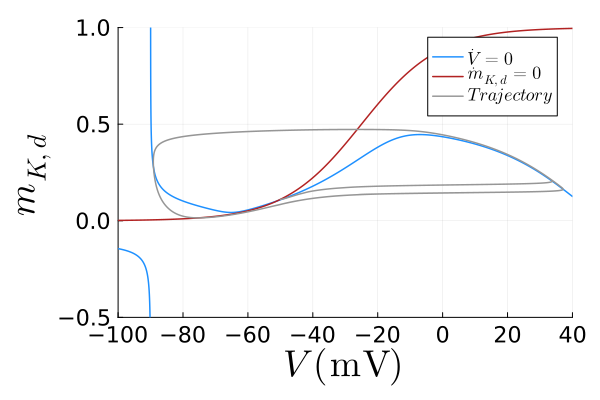

In [18]:
                         # Sodium current
dot_V(V, n) = (1/C) * (- gNa*m_inf_true(V)^3*h_inf(Vs(n))*(V-VNa) +
                    # Potassium current
                    - gKd*n^3*(V-VK) - gPacemaker*mPacemaker_inf(V)*(V-EPacemaker) +
                    # Passive currents
                    - gLNS*(V-VLNS)-0.05)

dot_mKd_20ms(V, n) = (1/20) * (n_inf(V) - n)

p = implicit_plot(dot_V, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
              aspect_ratio=:auto, linecolor=:dodgerblue, label=L"\dot V = 0")
implicit_plot!(dot_mKd_20ms, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
               aspect_ratio=:auto, linecolor=:firebrick, label=L"\dot m_{K,d} = 0")
plot!(x[1, :], x[2, :], linewidth=1.5, linecolor=myGray, label=L"Trajectory")
xlabel!(L"V\ (\mathrm{mV})")
ylabel!(L"m_{K,d}")
# savefig(p, "./figures/phase_plane_pacemaker.pdf")
# savefig(p, "./figures/phase_plane_pacemaker.svg")

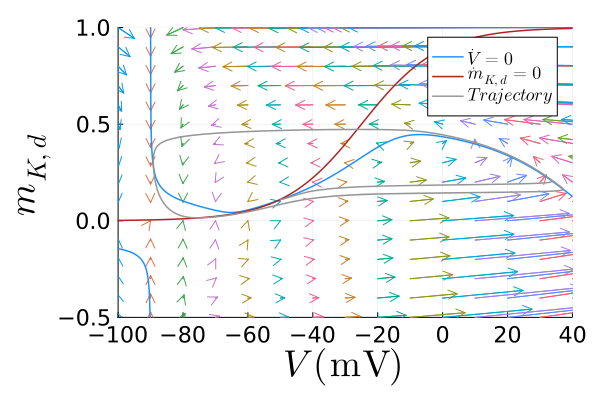

In [19]:
# Define the grid ranges
xx = -100:10:60
yy = -0.5:0.1:1.0

# Create grid using broadcasting
X = repeat(xx', length(yy), 1)   # transpose x to make rows
Y = repeat(yy, 1, length(xx))    # repeat y as columns

# Evaluate the vector field on the grid
U = dot_V.(X, Y)
V = dot_mKd.(X, Y)

# Plot the vector field
scale_factor = 0.05
quiver(X, Y, quiver=(scale_factor .* U, scale_factor .* V), arrow=true)
implicit_plot!(dot_V, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
              aspect_ratio=:auto, linecolor=:dodgerblue, label=L"\dot V = 0")
implicit_plot!(dot_mKd_20ms, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
               aspect_ratio=:auto, linecolor=:firebrick, label=L"\dot m_{K,d} = 0")
plot!(x[1, :], x[2, :], linewidth=1.5, linecolor=myGray, label=L"Trajectory")
xlabel!(L"V\ (\mathrm{mV})")
ylabel!(L"m_{K,d}")

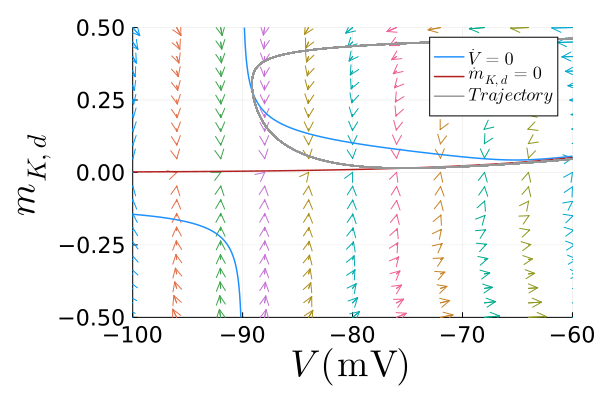

In [20]:
# Define the grid ranges
xx = -100:4: -60
yy = -0.5:0.05:0.5

# Create grid using broadcasting
X = repeat(xx', length(yy), 1)   # transpose x to make rows
Y = repeat(yy, 1, length(xx))    # repeat y as columns

# Evaluate the vector field on the grid
U = dot_V.(X, Y)
V = dot_mKd.(X, Y)

# Plot the vector field
scale_factor = 0.05
quiver(X, Y, quiver=(scale_factor .* U, scale_factor .* V), arrow=true)
implicit_plot!(dot_V, linewidth=1.5, xlims=(-100, -60), ylims=(-0.5, 0.5), 
              aspect_ratio=:auto, linecolor=:dodgerblue, label=L"\dot V = 0")
implicit_plot!(dot_mKd_20ms, linewidth=1.5, xlims=(-100, -60), ylims=(-0.5, 0.5), 
               aspect_ratio=:auto, linecolor=:firebrick, label=L"\dot m_{K,d} = 0")
plot!(x[1, :], x[2, :], linewidth=1.5, linecolor=myGray, label=L"Trajectory")
xlabel!(L"V\ (\mathrm{mV})")
ylabel!(L"m_{K,d}")

0.0

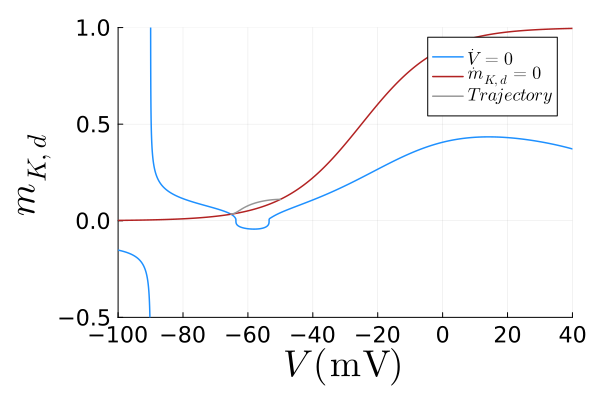

0.5

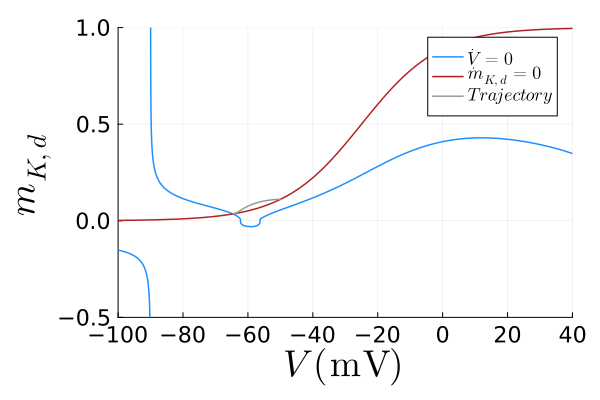

1.0

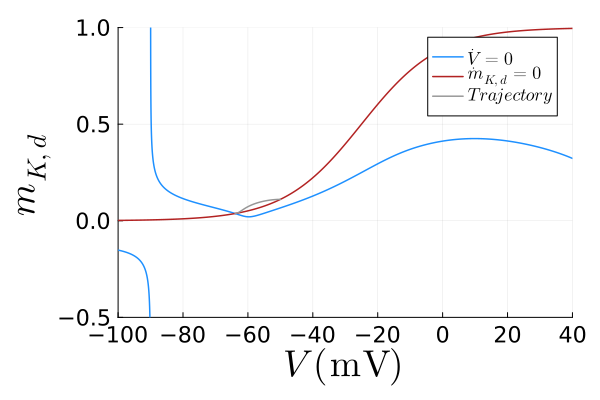

1.5

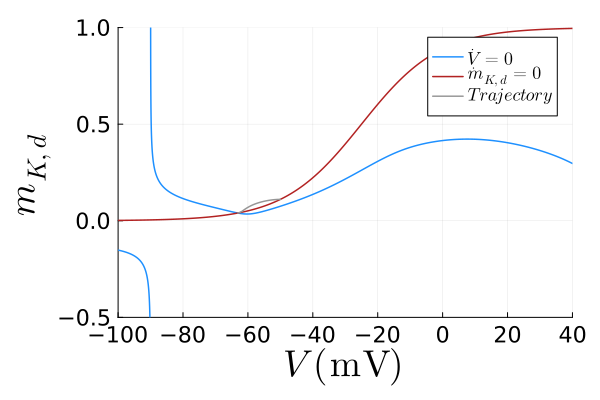

2.0

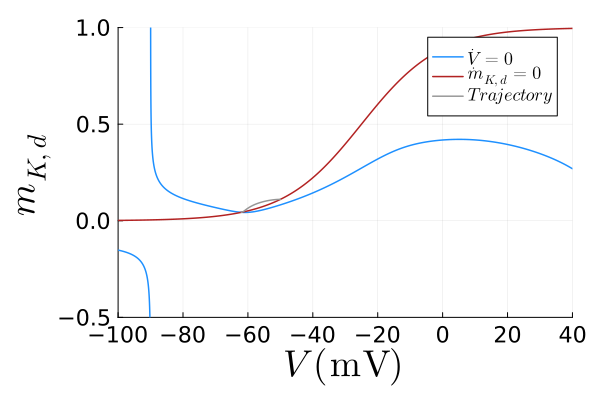

2.5

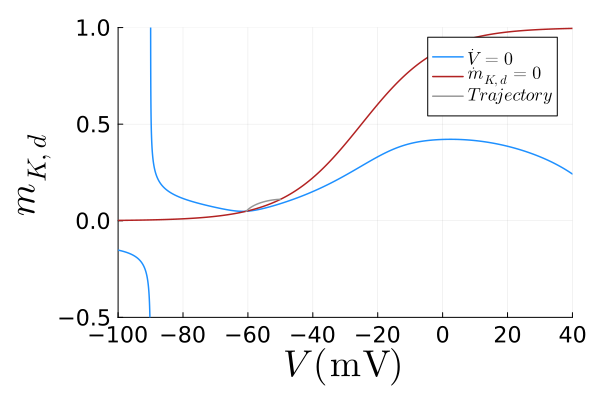

3.0

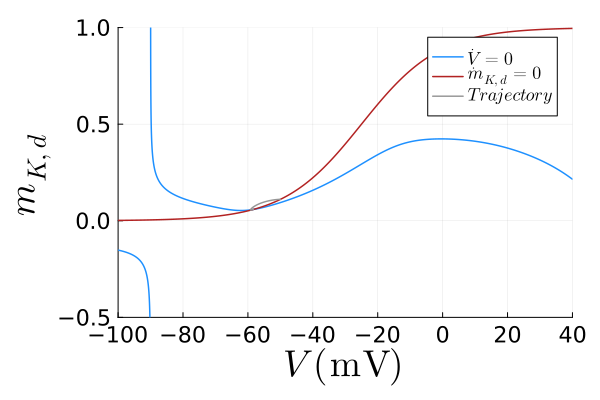

3.5

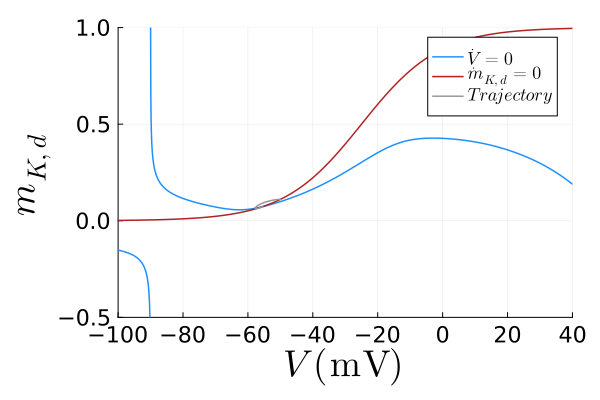

4.0

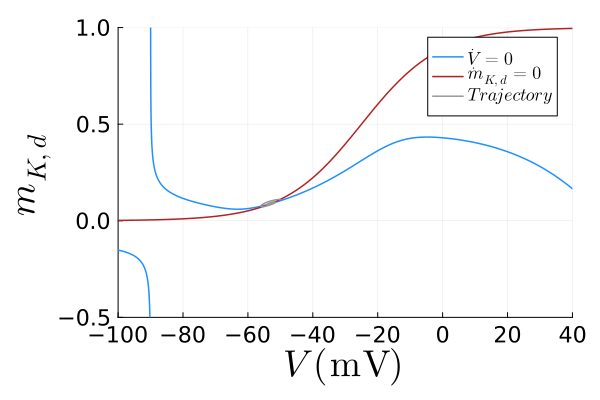

4.5

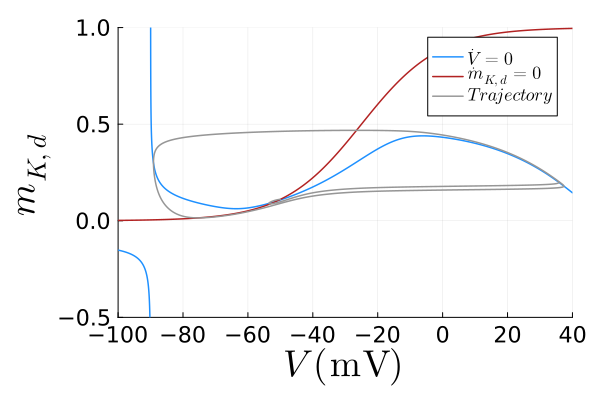

5.0

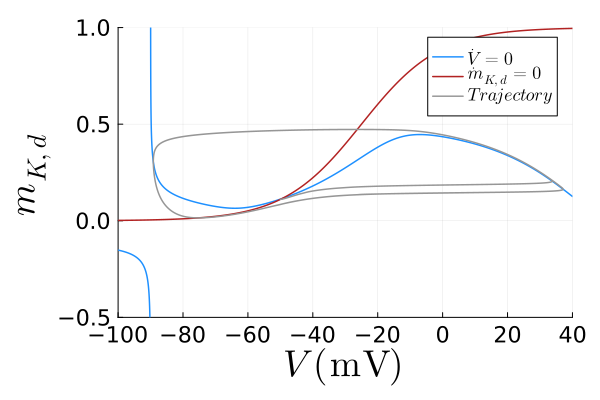

In [15]:
gNa        = 25. # Sodium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gPacemakers = 0:0.5:5 # Pacemaker current maximal conductance

# V_traj = zeros(length(gPacemakers), length(tt))
# n_traj = zeros(length(gPacemakers), length(tt))
for (i, gPacemaker) in enumerate(gPacemakers)
    # Input current definition
    Iapp(t) = 0 # pA
    p = (Iapp, gNa, gKd, gLNS, gPacemaker)

    # Initial conditions
    V0 = -50.
    x0 = [V0, n_inf(V0)]

    # Simulation
    prob = ODEProblem(DA_ODE_planar_true, x0, tspan, p) # Describing the problem
    sol = solve(prob; maxiters=1e6) # Solving the problem
    
    # Retrieving variables
    x            = sol(tt)
#     V_traj[i, :] = x[1, :]
#     n_traj[i, :] = x[2, :]
    
                             # Sodium current
    dot_V(V, n) = (1/C) * (- gNa*m_inf_true(V)^3*h_inf(Vs(n))*(V-VNa) +
                        # Potassium current
                        - gKd*n^3*(V-VK) - gPacemaker*mPacemaker_inf(V)*(V-EPacemaker) +
                        # Passive currents
                        - gLNS*(V-VLNS))

    dot_mKd(V, n) = n_inf(V) - n

    p = implicit_plot(dot_V, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
                  aspect_ratio=:auto, linecolor=:dodgerblue, label=L"\dot V = 0")
    implicit_plot!(dot_mKd, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
                   aspect_ratio=:auto, linecolor=:firebrick, label=L"\dot m_{K,d} = 0")
    plot!(x[1, :], x[2, :], linewidth=1.5, linecolor=myGray, label=L"Trajectory")
    xlabel!(L"V\ (\mathrm{mV})")
    ylabel!(L"m_{K,d}")
    display(gPacemaker)
    display(p)
end

0

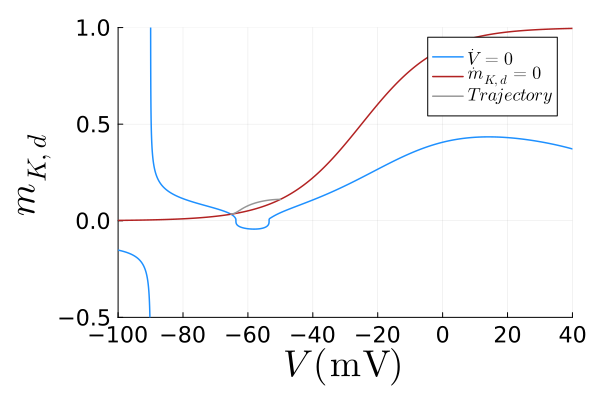

5

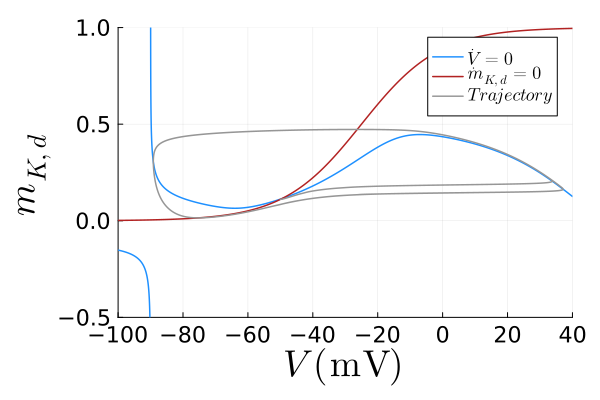

10

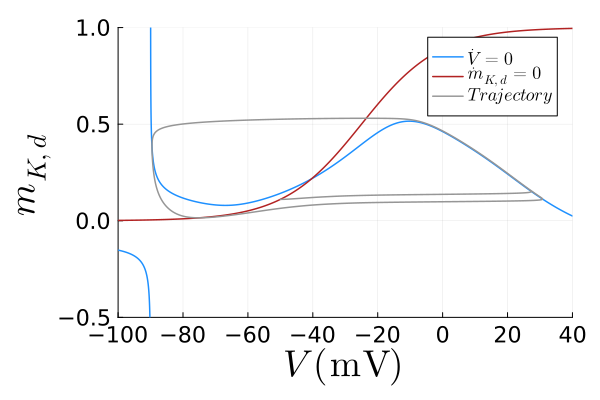

15

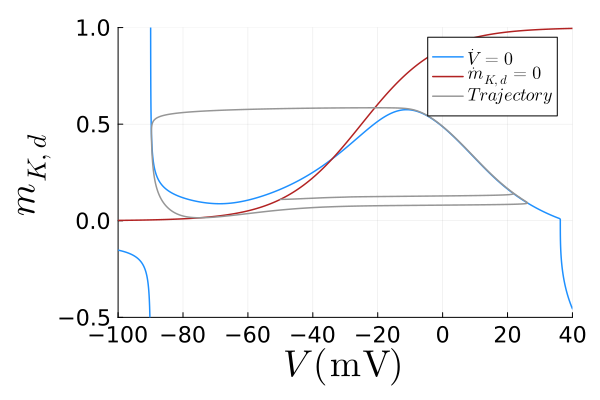

20

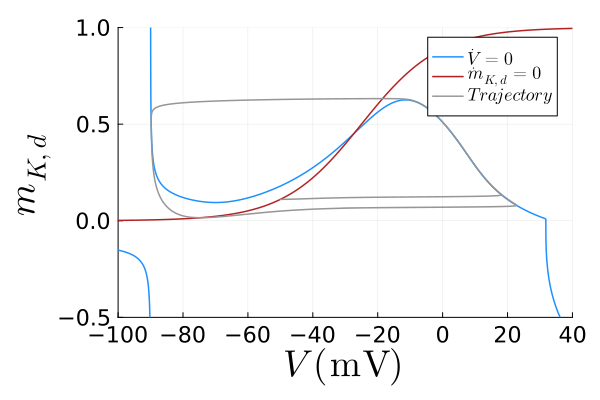

25

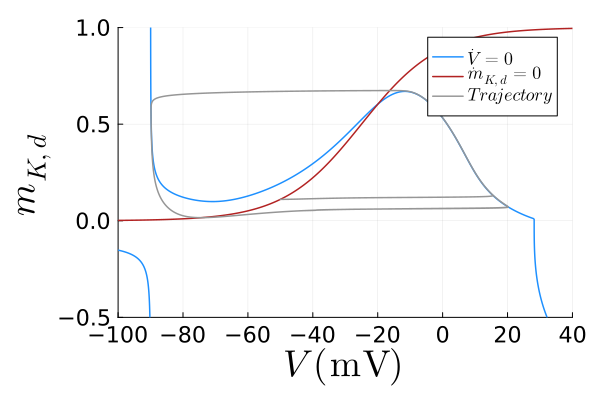

30

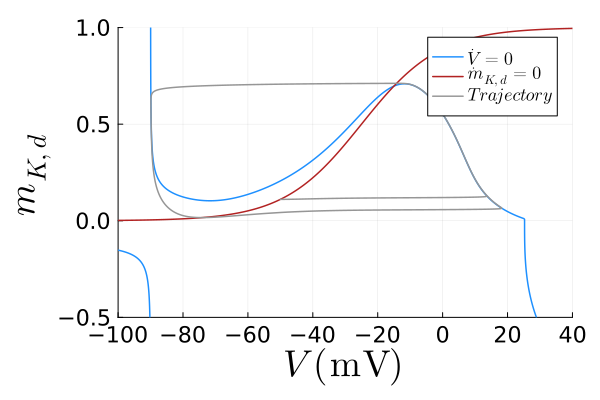

35

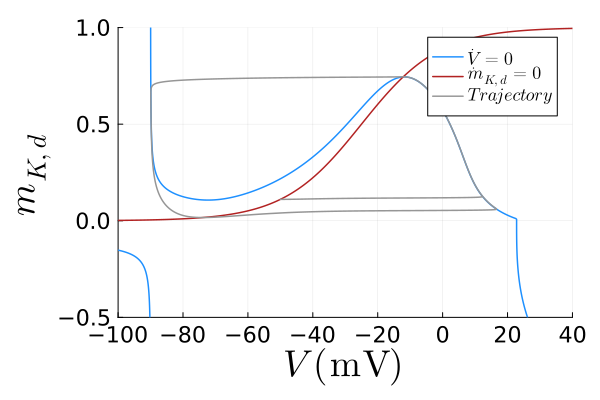

40

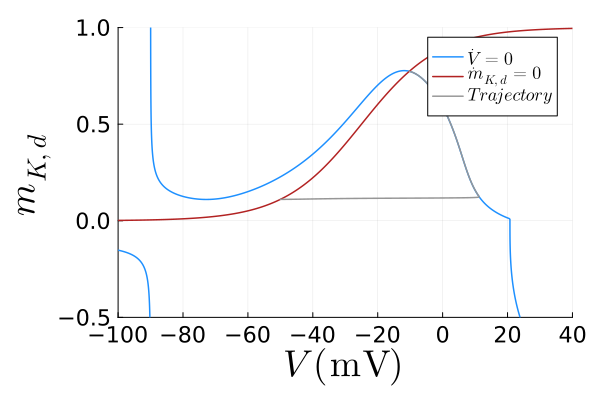

In [16]:
gNa        = 25. # Sodium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gPacemakers = 0:5:40 # Pacemaker current maximal conductance

# V_traj = zeros(length(gPacemakers), length(tt))
# n_traj = zeros(length(gPacemakers), length(tt))
for (i, gPacemaker) in enumerate(gPacemakers)
    # Input current definition
    Iapp(t) = 0 # pA
    p = (Iapp, gNa, gKd, gLNS, gPacemaker)

    # Initial conditions
    V0 = -50.
    x0 = [V0, n_inf(V0)]

    # Simulation
    prob = ODEProblem(DA_ODE_planar_true, x0, tspan, p) # Describing the problem
    sol = solve(prob; maxiters=1e6) # Solving the problem
    
    # Retrieving variables
    x            = sol(tt)
#     V_traj[i, :] = x[1, :]
#     n_traj[i, :] = x[2, :]
    
                             # Sodium current
    dot_V(V, n) = (1/C) * (- gNa*m_inf_true(V)^3*h_inf(Vs(n))*(V-VNa) +
                        # Potassium current
                        - gKd*n^3*(V-VK) - gPacemaker*mPacemaker_inf(V)*(V-EPacemaker) +
                        # Passive currents
                        - gLNS*(V-VLNS))

    dot_mKd(V, n) = n_inf(V) - n

    p = implicit_plot(dot_V, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
                  aspect_ratio=:auto, linecolor=:dodgerblue, label=L"\dot V = 0")
    implicit_plot!(dot_mKd, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
                   aspect_ratio=:auto, linecolor=:firebrick, label=L"\dot m_{K,d} = 0")
    plot!(x[1, :], x[2, :], linewidth=1.5, linecolor=myGray, label=L"Trajectory")
    xlabel!(L"V\ (\mathrm{mV})")
    ylabel!(L"m_{K,d}")
    display(gPacemaker)
    display(p)
end

# Without pacemaking

In [22]:
gNa        = 25. # Sodium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gPacemaker = 0 # Pacemaker current maximal conductance

# Input current definition
Iapp(t) = 0 # pA
p = (Iapp, gNa, gKd, gLNS, gPacemaker)

# Initial conditions
V0 = -0.
x0 = [V0, n_inf(V0)]

# Simulation
prob = ODEProblem(DA_ODE_planar_true, x0, tspan, p) # Describing the problem
sol = solve(prob; maxiters=1e6); # Solving the problem

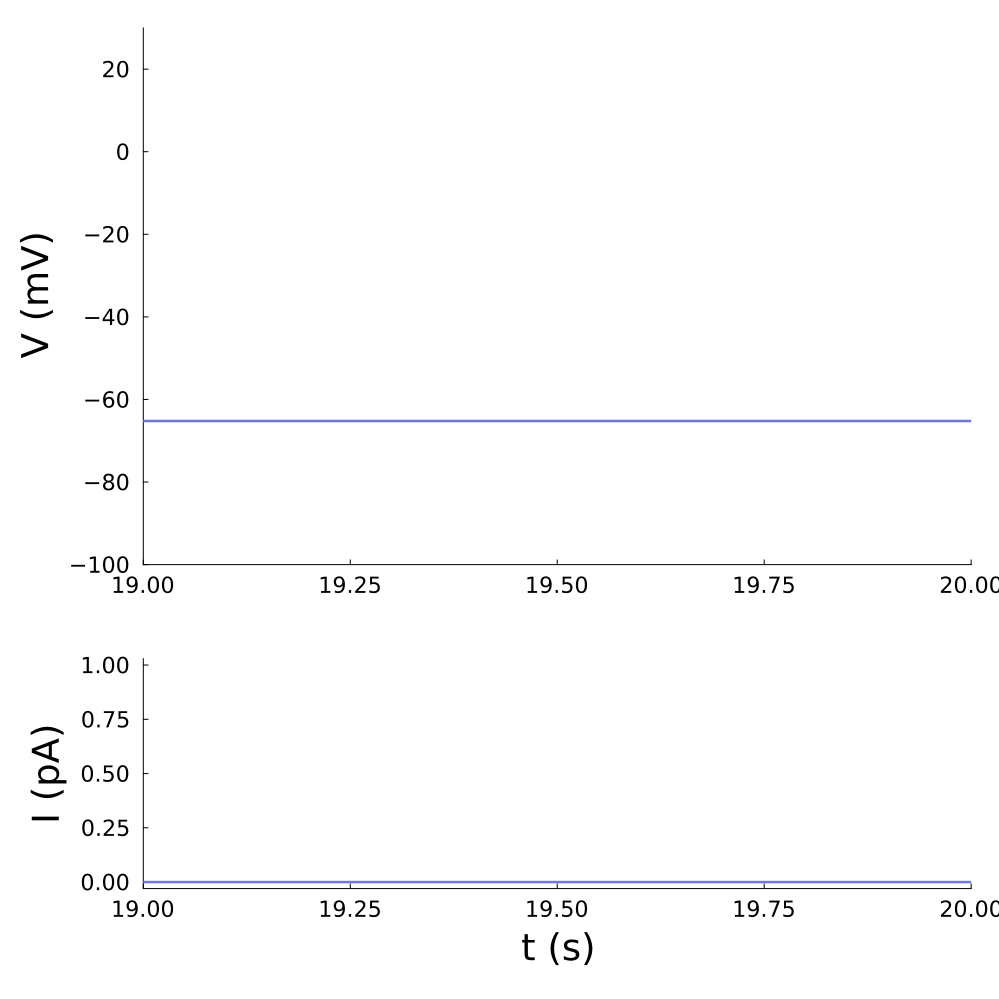

In [23]:
# Retrieving variables
x         = sol(tt)
V_plot    = x[1, :]
voltage = plot(tt./1e3, V_plot, linewidth=2.5, color=myDarkBlue, 
    legend=false, ylims=(-100, 30), margins=20Plots.px, size=(1200, 800))
ylabel!("V (mV)")

current = plot(tt./1e3, Iapp.(tt), linewidth=2.5, color=myDarkBlue,
    legend=false, margins=20Plots.px, size=(1200, 800))
ylabel!("I (pA)")
xlabel!("t (s)")

l = @layout [
    a{1.0*w, 0.70*h}
    b{1.0*w, 0.30*h}
]
VI = plot(voltage, current, layout=l, size=(1000, 1000), margins=20Plots.px, xlims=(19., 20.))
display(VI)

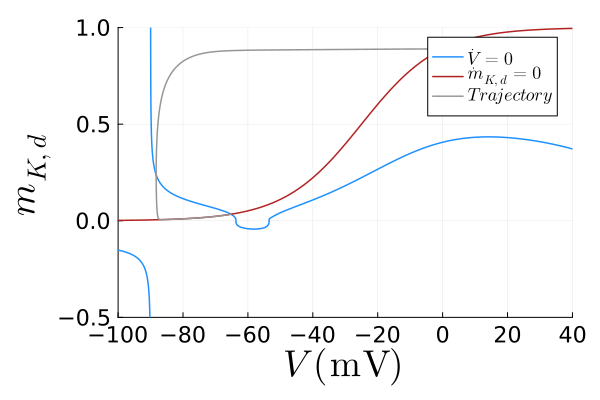

In [26]:
                         # Sodium current
dot_V(V, n) = (1/C) * (- gNa*m_inf_true(V)^3*h_inf(Vs(n))*(V-VNa) +
                    # Potassium current
                    - gKd*n^3*(V-VK) - gPacemaker*mPacemaker_inf(V)*(V-EPacemaker) +
                    # Passive currents
                    - gLNS*(V-VLNS))

dot_mKd(V, n) = n_inf(V) - n

p = implicit_plot(dot_V, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
              aspect_ratio=:auto, linecolor=:dodgerblue, label=L"\dot V = 0")
implicit_plot!(dot_mKd, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
               aspect_ratio=:auto, linecolor=:firebrick, label=L"\dot m_{K,d} = 0")
plot!(x[1, :], x[2, :], linewidth=1.5, linecolor=myGray, label=L"Trajectory")
xlabel!(L"V\ (\mathrm{mV})")
ylabel!(L"m_{K,d}")
# savefig(p, "./figures/phase_plane_adjusted.pdf")
# savefig(p, "./figures/phase_plane_adjusted.svg")

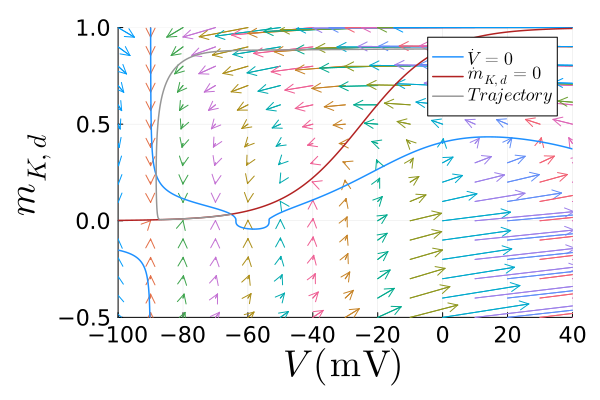

In [25]:
# Define the grid ranges
xx = -100:10:60
yy = -0.5:0.1:1.0

# Create grid using broadcasting
X = repeat(xx', length(yy), 1)   # transpose x to make rows
Y = repeat(yy, 1, length(xx))    # repeat y as columns

# Evaluate the vector field on the grid
U = dot_V.(X, Y)
V = dot_mKd.(X, Y)

# Plot the vector field
scale_factor = 0.05
quiver(X, Y, quiver=(scale_factor .* U, scale_factor .* V), arrow=true)
implicit_plot!(dot_V, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
              aspect_ratio=:auto, linecolor=:dodgerblue, label=L"\dot V = 0")
implicit_plot!(dot_mKd, linewidth=1.5, xlims=(-100, 40), ylims=(-0.5, 1), 
               aspect_ratio=:auto, linecolor=:firebrick, label=L"\dot m_{K,d} = 0")
plot!(x[1, :], x[2, :], linewidth=1.5, linecolor=myGray, label=L"Trajectory")
xlabel!(L"V\ (\mathrm{mV})")
ylabel!(L"m_{K,d}")

# 3D analysis

In [27]:
function DA_ODE_3D(du, u, p, t)
    # Parameters
    Iapp       = p[1](t) # Amplitude of external current
    gNa        = p[2] # Sodium current maximal conductance
    gKd        = p[3] # Delayed-rectifier potassium current maximal conductance
    gLNS       = p[4] # Leak non specific current maximal conductance
    gPacemaker = p[5] # Pacemaking current maximal conductance
    tau        = p[6] # Multiplicative time constant for pacemaker current
    
    # Variables
    V          = u[1] # Membrane potential
    n          = u[2] # Delayed-rectifier potassium current activation
    mPacemaker = u[3] # Pacemaker current activation
    
    # ODEs
                    # Sodium current
    du[1] = (1/C) * (- gNa*m_inf_true(V)^3*h_inf(Vs(n))*(V-VNa) +
                    # Potassium current
                    - gKd*n^3*(V-VK) - gPacemaker*mPacemaker*(V-EPacemaker) +
                    # Passive currents
                    - gLNS*(V-VLNS) +
                    # Stimulation currents
                    + Iapp)

    du[2] = (1/tau_n(V)) * (n_inf(V) - n)
    du[3] = (1/(tau*tau_m(V))) * (mPacemaker_inf(V) - mPacemaker)
end

DA_ODE_3D (generic function with 1 method)

In [28]:
gNa        = 25. # Sodium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance
tau        = 1 # Multiplicative time constant for pacemaker current

# Input current definition
Iapp(t) = 0 # pA
p = (Iapp, gNa, gKd, gLNS, gPacemaker, tau)

# Initial conditions
V0 = -50.
x0 = [V0, n_inf(V0), mPacemaker_inf(V0)]

# Simulation
prob_3D = ODEProblem(DA_ODE_3D, x0, tspan, p) # Describing the problem
sol_3D = solve(prob_3D; maxiters=1e6); # Solving the problem

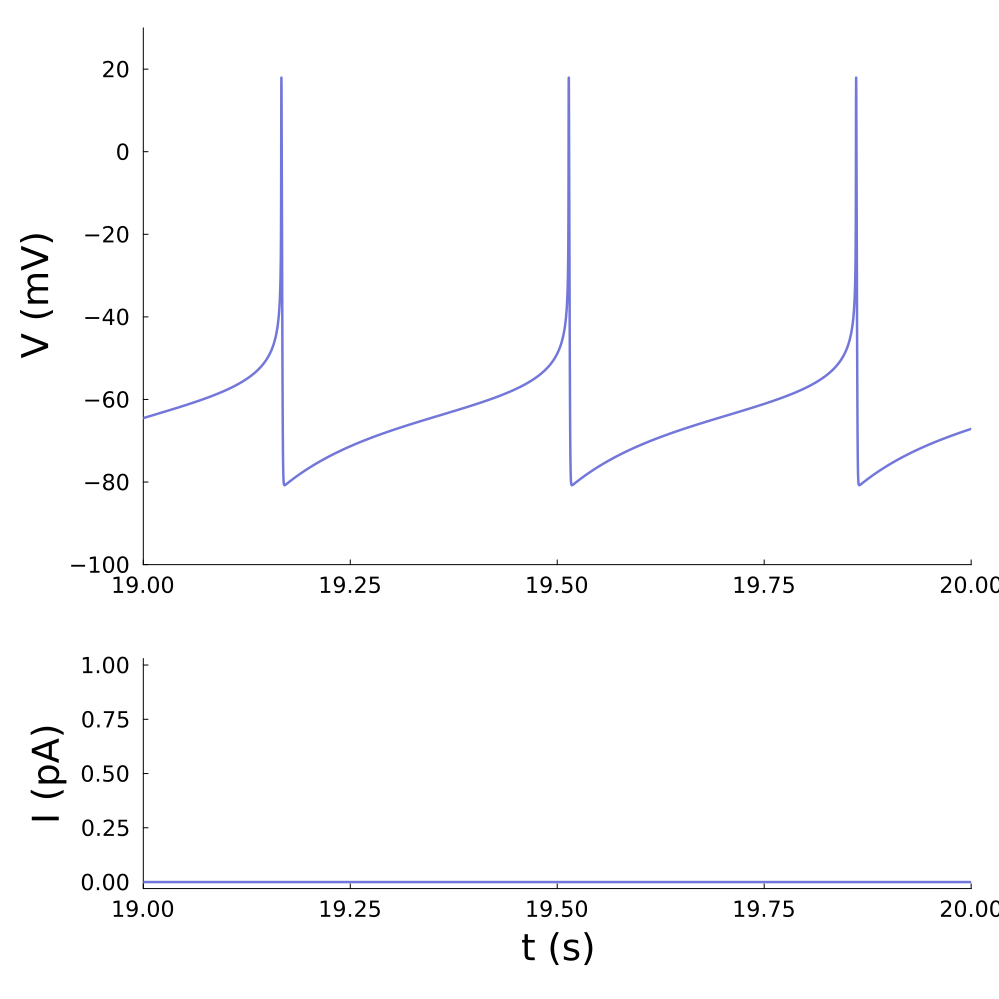

In [29]:
# Retrieving variables
x_3D      = sol_3D(tt)
V_plot3D  = x_3D[1, :]
voltage = plot(tt./1e3, V_plot3D, linewidth=2.5, color=myDarkBlue, 
    legend=false, ylims=(-100, 30), margins=20Plots.px, size=(1200, 800))
ylabel!("V (mV)")

current = plot(tt./1e3, Iapp.(tt), linewidth=2.5, color=myDarkBlue,
    legend=false, margins=20Plots.px, size=(1200, 800))
ylabel!("I (pA)")
xlabel!("t (s)")

l = @layout [
    a{1.0*w, 0.70*h}
    b{1.0*w, 0.30*h}
]
VI = plot(voltage, current, layout=l, size=(1000, 1000), margins=20Plots.px, xlims=(19., 20.))
display(VI)

In [30]:
tt_5 = 0. : 0.01 : 5000

# Initializing some variables
mPacemaker0s = range(0, 1, length=10)
V_traj_m0s = zeros(length(mPacemaker0s), length(tt_5))
n_traj_m0s = zeros(length(mPacemaker0s), length(tt_5))
m_traj_m0s = zeros(length(mPacemaker0s), length(tt_5))

gNa        = 25. # Sodium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance
tau        = 1 # Multiplicative time constant for pacemaker current

# Input current definition
Iapp(t) = 0 # pA
p = (Iapp, gNa, gKd, gLNS, gPacemaker, tau)

# Initial conditions
V0 = -50.

for (i, mPacemaker0) in enumerate(mPacemaker0s)
    x0 = [V0, n_inf(V0), mPacemaker0]

    # Simulation
    prob_3D = ODEProblem(DA_ODE_3D, x0, (0, 5000), p) # Describing the problem
    sol_3D = solve(prob_3D; maxiters=1e6) # Solving the problem
    
    # Retrieving variables
    x_3D              = sol_3D(tt_5)
    V_traj_m0s[i, :]  = x_3D[1, :]
    n_traj_m0s[i, :]  = x_3D[2, :]
    m_traj_m0s[i, :]  = x_3D[3, :]
end

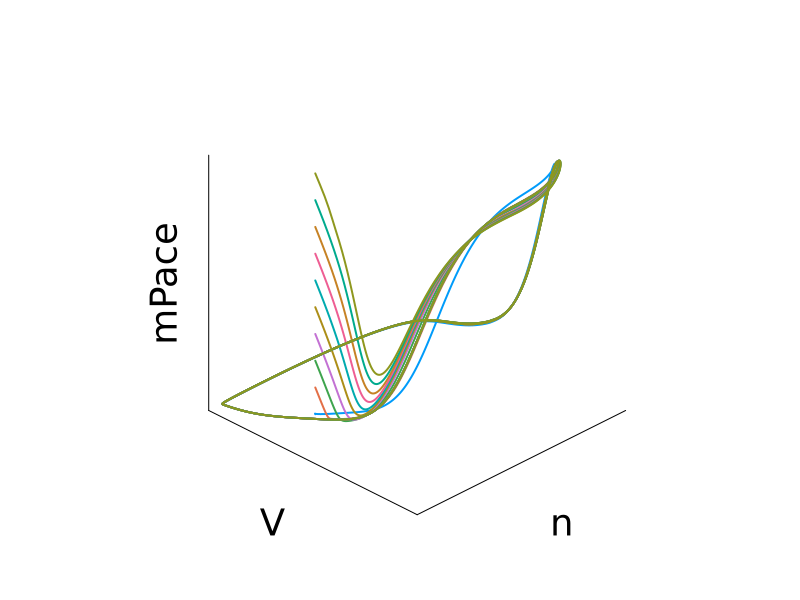

In [31]:
# Initialize the plot
plt = plot(size=(800, 600))

# Loop over each trajectory
for i = 1 : length(mPacemaker0s)
    plot!(plt, V_traj_m0s[i, :], n_traj_m0s[i, :], m_traj_m0s[i, :], label="", lw=2)
end

xlabel!(plt, "V")
ylabel!(plt, "n")
zlabel!(plt, "mPace")

# Remove axis ticks
plot!(plt, xticks=false, yticks=false, zticks=false)

plot!(plt, camera=(45, 30))

display(plt)

In [32]:
tt_5 = 0. : 0.01 : 5000

# Initializing some variables
taus = 10 .^ range(-2, stop=1, length=10)
V_traj_m0s = zeros(length(mPacemaker0s), length(tt_5))
n_traj_m0s = zeros(length(mPacemaker0s), length(tt_5))
m_traj_m0s = zeros(length(mPacemaker0s), length(tt_5))

gNa        = 25. # Sodium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
x0 = [V0, n_inf(V0), mPacemaker_inf(V0)]

for (i, tau) in enumerate(taus)
    p = (Iapp, gNa, gKd, gLNS, gPacemaker, tau)

    # Simulation
    prob_3D = ODEProblem(DA_ODE_3D, x0, (0, 5000), p) # Describing the problem
    sol_3D = solve(prob_3D; maxiters=1e6) # Solving the problem
    
    # Retrieving variables
    x_3D              = sol_3D(tt_5)
    V_traj_m0s[i, :]  = x_3D[1, :]
    n_traj_m0s[i, :]  = x_3D[2, :]
    m_traj_m0s[i, :]  = x_3D[3, :]
end

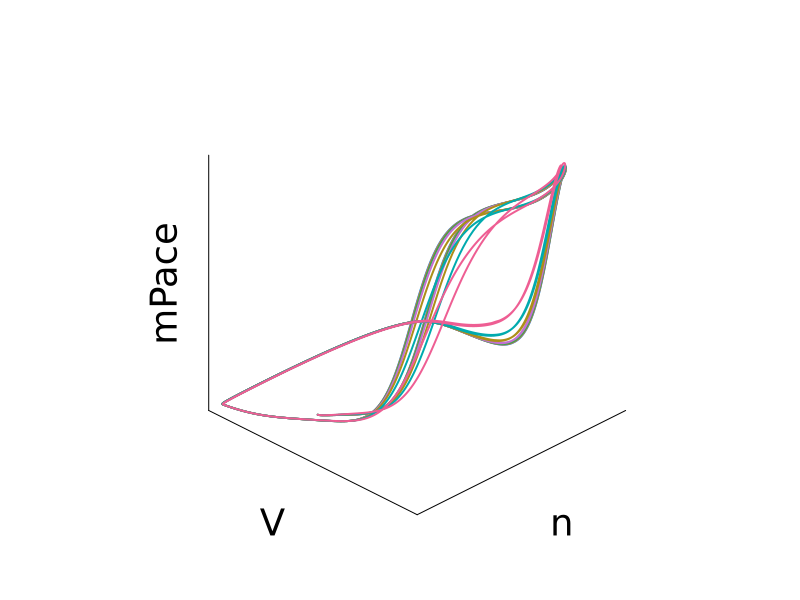

In [33]:
# Initialize the plot
plt = plot(size=(800, 600))

# Loop over each trajectory
for i = 1 : 7
    plot!(plt, V_traj_m0s[i, :], n_traj_m0s[i, :], m_traj_m0s[i, :], label="", lw=2)
end

xlabel!(plt, "V")
ylabel!(plt, "n")
zlabel!(plt, "mPace")

# Remove axis ticks
plot!(plt, xticks=false, yticks=false, zticks=false)

plot!(plt, camera=(45, 30))

display(plt)

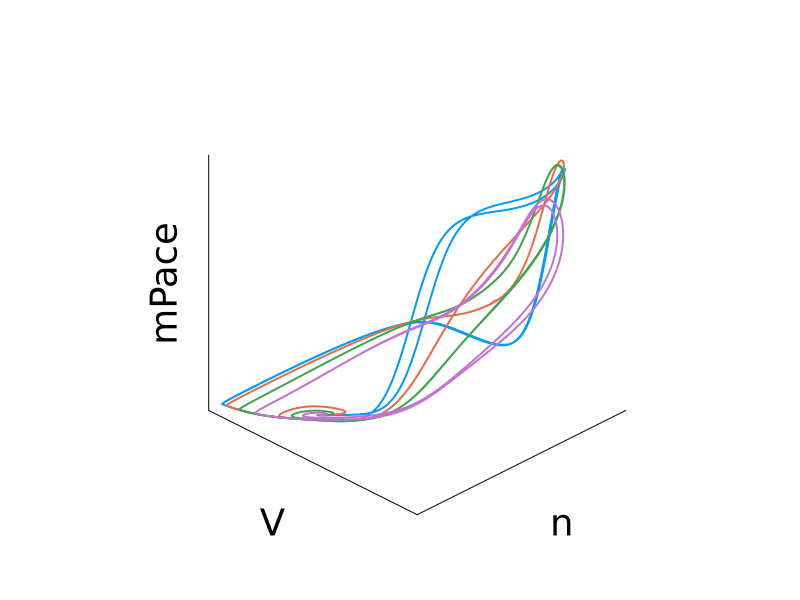

In [34]:
# Initialize the plot
plt = plot(size=(800, 600))

# Loop over each trajectory
for i in (1, 8, 9, 10)
    plot!(plt, V_traj_m0s[i, :], n_traj_m0s[i, :], m_traj_m0s[i, :], label="", lw=2)
end

xlabel!(plt, "V")
ylabel!(plt, "n")
zlabel!(plt, "mPace")

# Remove axis ticks
plot!(plt, xticks=false, yticks=false, zticks=false)

plot!(plt, camera=(45, 30))

display(plt)

In [35]:
display(taus)

10-element Vector{Float64}:
  0.010000000000000002
  0.021544346900318832
  0.046415888336127795
  0.1
  0.2154434690031884
  0.4641588833612779
  1.0
  2.154434690031884
  4.641588833612778
 10.0